<center>
    <img src="https://i.ibb.co/dphSYt0/carbon-Footprint.png">
</center>



The goal of linear regression in the Carbon Footprint Tracker App is to predict a user's carbon footprint percentage based on their daily habits and lifestyle inputs—such as electronic device usage, transportation expenditures, grocery spending and dietary habits.

The linear regression model is trained and optimized using gradient descent, which minimizes the error between the predicted and actual carbon footprint values. Key evaluation metrics such as **Mean Squared Error (MSE)** and **R²** Score are used to measure the model's performance.

**The model is visually validated using these meaningful data visualizations:**

* **Correlation Heatmap** to highlight the relationships between the input variables and their influence on the carbon footprint.

* **Scatter Plot** to display the linear relationship between the input variables and the predicted carbon footprint, visually showcasing the best-fit line after training.

The app will also compare the performance of the **Linear Regression model** against **Decision Trees** and **Random Forests**, using the same evaluation metrics to identify the best-performing model. The model with the **lowest loss (as determined by MSE)** will be saved for deployment.

The final script will incorporate functionality to make predictions on individual user inputs, allowing seamless integration with the app's API.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d dumanmesut/individual-carbon-footprint-calculation

Dataset URL: https://www.kaggle.com/datasets/dumanmesut/individual-carbon-footprint-calculation
License(s): CC0-1.0
  0% 0.00/236k [00:00<?, ?B/s]
100% 236k/236k [00:00<00:00, 30.7MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/individual-carbon-footprint-calculation.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
#import necessary package

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import math
from scipy.stats import skew
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# **Load the dataset**

In [6]:
path = "/content/Carbon Emission.csv"
df = pd.read_csv(path)

# Print some part of the dataset
df.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Body Type                      10000 non-null  object
 1   Sex                            10000 non-null  object
 2   Diet                           10000 non-null  object
 3   How Often Shower               10000 non-null  object
 4   Heating Energy Source          10000 non-null  object
 5   Transport                      10000 non-null  object
 6   Vehicle Type                   3279 non-null   object
 7   Social Activity                10000 non-null  object
 8   Monthly Grocery Bill           10000 non-null  int64 
 9   Frequency of Traveling by Air  10000 non-null  object
 10  Vehicle Monthly Distance Km    10000 non-null  int64 
 11  Waste Bag Size                 10000 non-null  object
 12  Waste Bag Weekly Count         10000 non-null  int64 
 13  Ho

## **Workflow Before Visualization:**

*   **Check Data Types** to ensure numerical columns are ready for modeling and identify any categorical variables
*   **Check Shape** to verify the number of rows and columns
*   View **Statistical Summary** to understand the range and distribution of data
*   **Check for, handle missing values** and clean the dataset afterwards

In [8]:
df.dtypes # check data types

,0
Body Type,object
Sex,object
Diet,object
How Often Shower,object
Heating Energy Source,object
Transport,object
Vehicle Type,object
Social Activity,object
Monthly Grocery Bill,int64
Frequency of Traveling by Air,object


In [9]:
# check shape

print("Shape of DataFrame:", df.shape)

Shape of DataFrame: (10000, 20)


In [10]:
df.describe() #statistical summary

,Monthly Grocery Bill,Vehicle Monthly Distance Km,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,CarbonEmission
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,173.875200,2031.485900,4.024600,12.139200,25.109000,11.889100,2269.147300
std,72.234018,2769.715597,1.990375,7.106369,14.698725,7.277218,1017.675247
min,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000,306.000000
25%,111.000000,69.000000,2.000000,6.000000,13.000000,6.000000,1538.000000
50%,173.000000,823.000000,4.000000,12.000000,25.000000,12.000000,2080.000000
75%,237.000000,2516.750000,6.000000,18.000000,38.000000,18.000000,2768.000000
max,299.000000,9999.000000,7.000000,24.000000,50.000000,24.000000,8377.000000


In [11]:
# Check for missing values
df.isnull().sum()

,0
Body Type,0
Sex,0
Diet,0
How Often Shower,0
Heating Energy Source,0
Transport,0
Vehicle Type,6721
Social Activity,0
Monthly Grocery Bill,0
Frequency of Traveling by Air,0


## **Key Observations:**

1. Vehicle Type has 6,721 missing values, which is the only column with missing data and needs handling.
2. All other columns have no missing values, so no further handling for missing data is necessary

### Checking if the zeros in Vehicle Monthly Distance Km are errors or represent legitimate records (e.g., no distance traveled)

In [12]:
# Check patterns in rows with Vehicle Monthly Distance Km = 0
zero_distance_rows = df[df['Vehicle Monthly Distance Km'] == 0]
print(zero_distance_rows[['Monthly Grocery Bill', 'Transport', 'Vehicle Type']].head())

     Monthly Grocery Bill     Transport Vehicle Type
415                   232  walk/bicycle          NaN
478                   116  walk/bicycle          NaN
831                   249  walk/bicycle          NaN
841                   234  walk/bicycle          NaN
899                   188  walk/bicycle          NaN


- The subset of rows indicates that all vehicles with Vehicle Type = lpg and Transport = walk/bicycle have recorded zeros for Vehicle Monthly Distance Km.
- This combination makes sense because if individuals primarily rely on walking or biking, their vehicle might not be used, resulting in zero distances.

In [13]:
# Frequency of zero values
zero_frequency = (df['Vehicle Monthly Distance Km'] == 0).mean()
print(f"Percentage of zero values in Vehicle Monthly Distance Km: {zero_frequency * 100:.2f}%")

Percentage of zero values in Vehicle Monthly Distance Km: 0.32%


- The proportion of zeros is 0.32%, which is very low. This indicates that these zeros are rare and might not significantly impact the overall dataset.

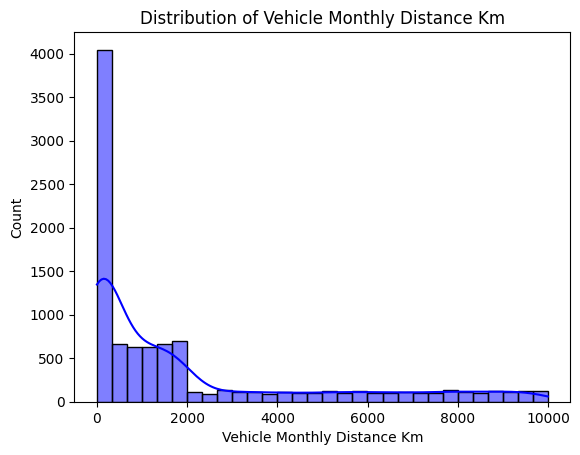

In [14]:
# Plot the distribution of Vehicle Monthly Distance Km
sns.histplot(df['Vehicle Monthly Distance Km'], bins=30, kde=True, color='blue')
plt.title('Distribution of Vehicle Monthly Distance Km')
plt.show()

### Observation:

- The data is right-skewed, with most vehicles traveling lower monthly distances and fewer vehicles accumulating higher distances
- The histogram indicates a bar at zero, confirming the presence of vehicles with no recorded distance for the month
- The zeros could represent valid cases (vehicles not used for the month) or data issues. Based on my earlier investigation, these zeros appear to be valid and should be retained

In [15]:
# Check skewness
carbonemission_skewness = skew(df['CarbonEmission'])
print(f"Skewness of CarbonEmission: {carbonemission_skewness}")

Skewness of CarbonEmission: 1.1578985661604457


The skewness of CarbonEmission is 1.16, which indicates a moderately high positive skew

In [16]:
# Use log-transformed features for modeling
df['Log_Vehicle_Monthly_Distance_Km'] = np.log1p(df['Vehicle Monthly Distance Km'])
df['Log_CarbonEmission'] = np.log1p(df['CarbonEmission'])

In [17]:
# Check the skewness after log transformation
print("Vehicle Skewness after log:", skew(df['Log_Vehicle_Monthly_Distance_Km']))
print("CarbonEmission Skewness after log:", skew(df['Log_CarbonEmission']))

# Describe the transformed data
df[['Log_Vehicle_Monthly_Distance_Km', 'Log_CarbonEmission']].describe()

Vehicle Skewness after log: -0.3629334416286228
CarbonEmission Skewness after log: -0.10428255663700574


,Log_Vehicle_Monthly_Distance_Km,Log_CarbonEmission
count,10000.000000,10000.000000
mean,6.135434,7.632555
std,2.145238,0.439442
min,0.000000,5.726848
25%,4.248495,7.338888
50%,6.714170,7.640604
75%,7.831119,7.926242
max,9.210340,9.033365


- Vehicle Monthly Distance Km: Skewness has reduced from 1.48 to -0.36, indicating a near-symmetric distribution with slight left skew

- CarbonEmission: Skewness has reduced from 1.16 to -0.10, which is almost perfectly symmetric

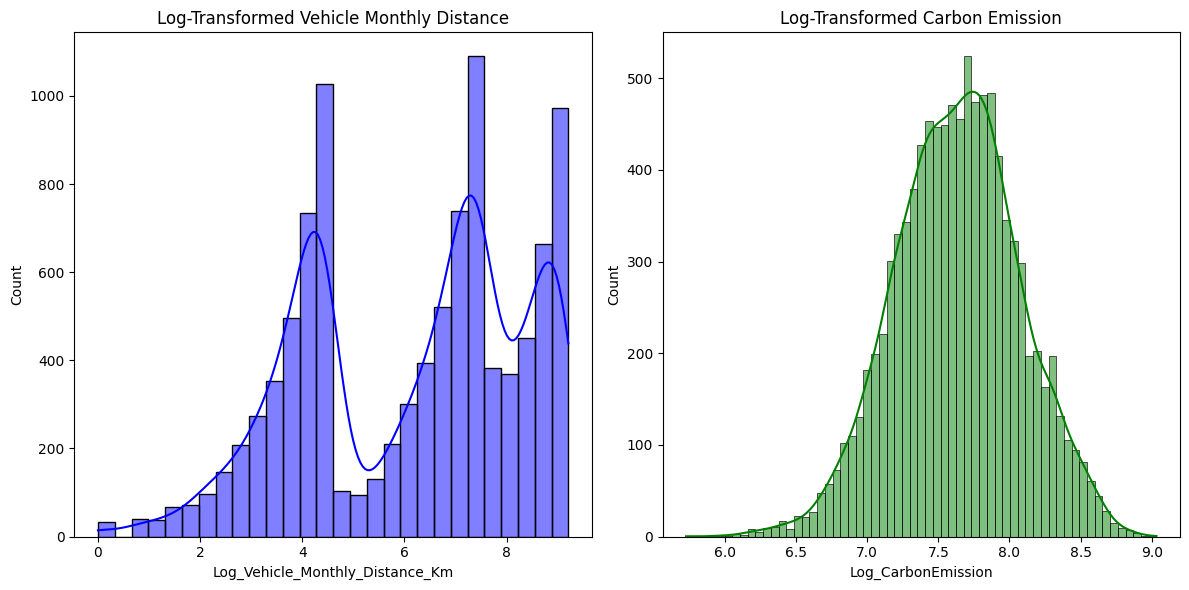

In [18]:
# Plot histograms with KDE for the log-transformed variables
plt.figure(figsize=(12, 6))

# Vehicle Monthly Distance
plt.subplot(1, 2, 1)
sns.histplot(df['Log_Vehicle_Monthly_Distance_Km'], kde=True, color='blue')
plt.title('Log-Transformed Vehicle Monthly Distance')

# CarbonEmission
plt.subplot(1, 2, 2)
sns.histplot(df['Log_CarbonEmission'], kde=True, color='green')
plt.title('Log-Transformed Carbon Emission')

plt.tight_layout()
plt.show()

**Log-Transformed Distributions**
1. Vehicle Monthly Distance:
- The distribution is slightly right-skewed but significantly improved compared to the original.
- The peak at 6.5 (log scale) translates to approximately 670 km on the original scale, representing the typical monthly distance traveled.

2. Carbon Emission:
- The distribution is more symmetrical, showing better normality than the distance variable.
- The peak at 7.5 (log scale) corresponds to approximately 1800 kg on the original scale, indicating the typical carbon emissions.

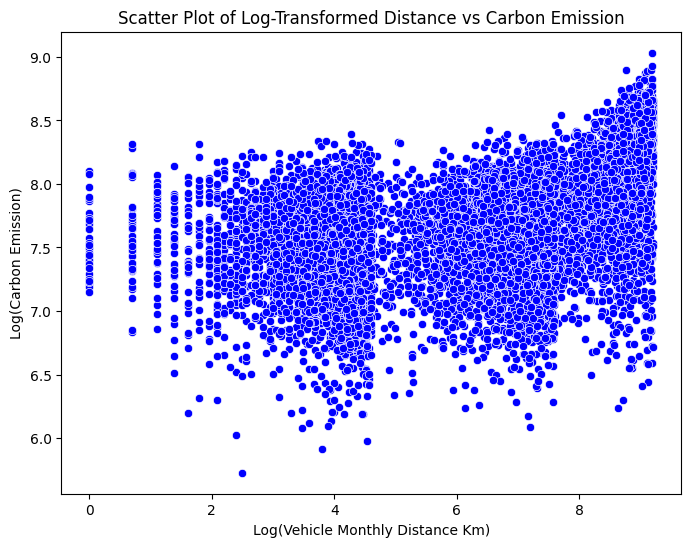

In [19]:
# Scatter plot of log-transformed variables
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Log_Vehicle_Monthly_Distance_Km'], y=df['Log_CarbonEmission'], color='blue')
plt.title('Scatter Plot of Log-Transformed Distance vs Carbon Emission')
plt.xlabel('Log(Vehicle Monthly Distance Km)')
plt.ylabel('Log(Carbon Emission)')
plt.show()

Key Points:

- Positive Correlation: The upward trend of the points indicates a positive correlation between the two variables. This means that as one variable increases, the other tends to increase as well.
- Spread of Data: The data points are spread out, suggesting some variability in the relationship. This could be due to factors like vehicle type, driving conditions, or fuel efficiency.

Interpretation:

The plot suggests that vehicles that travel longer distances tend to emit more carbon. This is expected, as more driving leads to increased fuel consumption and, consequently, higher emissions.

In [20]:
# Check basic statistics to detect anomalies
df['Vehicle Monthly Distance Km'].describe()

# Check for unusually low values (other than zero)
unusual_low_values = df[df['Vehicle Monthly Distance Km'] < 1]  # Any values less than 1
print(f"Unusual low values in 'Vehicle Monthly Distance Km':")
unusual_low_values

# Check for high values (e.g., more than 10,000 km/month)
high_values = df[df['Vehicle Monthly Distance Km'] > 10000]
print(f"Unusually high values in 'Vehicle Monthly Distance Km':", high_values)

Unusual low values in 'Vehicle Monthly Distance Km':
Unusually high values in 'Vehicle Monthly Distance Km': Empty DataFrame
Columns: [Body Type, Sex, Diet, How Often Shower, Heating Energy Source, Transport, Vehicle Type, Social Activity, Monthly Grocery Bill, Frequency of Traveling by Air, Vehicle Monthly Distance Km, Waste Bag Size, Waste Bag Weekly Count, How Long TV PC Daily Hour, How Many New Clothes Monthly, How Long Internet Daily Hour, Energy efficiency, Recycling, Cooking_With, CarbonEmission, Log_Vehicle_Monthly_Distance_Km, Log_CarbonEmission]
Index: []

[0 rows x 22 columns]


In [21]:
# create a feature that captures this context (e.g., Vehicle Used or Not) to help model interpret these cases more effectively

# Create a binary feature indicating whether the vehicle was used
df['Vehicle_Used'] = df['Vehicle Monthly Distance Km'].apply(lambda x: 1 if x > 0 else 0)

# Check distribution
df['Vehicle_Used'].value_counts()

,count
Vehicle_Used,
1,9968
0,32


The newly created Vehicle_Used feature successfully captures whether the vehicle was used or not during a particular month:

- 1 (Used): 9968 vehicles were used (distance > 0).
- 0 (Not Used): 32 vehicles were not used (distance = 0).

# **One-Hot Encoding for Categorical Variables**

From the dataset, most of the categorical variables are nominal, and one-hot encoding is the best practice for such data

In [22]:
# Select categorical columns (object type)
categorical_cols = df.select_dtypes(include=['object']).columns

# Perform one-hot encoding on categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Display the first few rows of the encoded DataFrame
df_encoded.head()

,Monthly Grocery Bill,Vehicle Monthly Distance Km,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,CarbonEmission,Log_Vehicle_Monthly_Distance_Km,Log_CarbonEmission,Vehicle_Used,...,Cooking_With_['Oven'],"Cooking_With_['Stove', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave']","Cooking_With_['Stove', 'Oven', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave']","Cooking_With_['Stove', 'Oven']",Cooking_With_['Stove'],Cooking_With_[]
0,230,210,4,7,26,1,2238,5.351858,7.713785,1,...,False,False,False,False,False,False,False,True,False,False
1,114,9,3,9,38,5,1892,2.302585,7.545918,1,...,False,False,False,True,False,False,False,False,False,False
2,138,2472,1,14,47,6,2595,7.813187,7.861727,1,...,False,False,False,False,False,False,False,False,False,False
3,157,74,3,20,5,7,1074,4.317488,6.980076,1,...,False,False,False,False,False,False,False,False,False,False
4,266,8457,1,3,5,6,4743,9.042868,8.464636,1,...,True,False,False,False,False,False,False,False,False,False


In [23]:
# Check data types to confirm that True/False are converted to numeric (0 or 1)

df_encoded.dtypes

,0
Monthly Grocery Bill,int64
Vehicle Monthly Distance Km,int64
Waste Bag Weekly Count,int64
How Long TV PC Daily Hour,int64
How Many New Clothes Monthly,int64
...,...
"Cooking_With_['Stove', 'Oven', 'Microwave', 'Grill', 'Airfryer']",bool
"Cooking_With_['Stove', 'Oven', 'Microwave']",bool
"Cooking_With_['Stove', 'Oven']",bool
Cooking_With_['Stove'],bool


Even after performing the one-hot encoding, some of the columns are still of boolean type (bool), showing as True/False rather than 1/0.

In [24]:
# Convert all boolean columns to 1 and 0
for col in df_encoded.select_dtypes(include=['bool']).columns:
    df_encoded[col] = df_encoded[col].astype(int)

# Check the result
df_encoded.head()

,Monthly Grocery Bill,Vehicle Monthly Distance Km,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,CarbonEmission,Log_Vehicle_Monthly_Distance_Km,Log_CarbonEmission,Vehicle_Used,...,Cooking_With_['Oven'],"Cooking_With_['Stove', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave']","Cooking_With_['Stove', 'Oven', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave']","Cooking_With_['Stove', 'Oven']",Cooking_With_['Stove'],Cooking_With_[]
0,230,210,4,7,26,1,2238,5.351858,7.713785,1,...,0,0,0,0,0,0,0,1,0,0
1,114,9,3,9,38,5,1892,2.302585,7.545918,1,...,0,0,0,1,0,0,0,0,0,0
2,138,2472,1,14,47,6,2595,7.813187,7.861727,1,...,0,0,0,0,0,0,0,0,0,0
3,157,74,3,20,5,7,1074,4.317488,6.980076,1,...,0,0,0,0,0,0,0,0,0,0
4,266,8457,1,3,5,6,4743,9.042868,8.464636,1,...,1,0,0,0,0,0,0,0,0,0


In [25]:
# Calculate variance of each column
variances = df_encoded.var()

# Drop columns with variance lower than a threshold (e.g., 0.01)
low_variance_columns = variances[variances < 0.01].index
df_cleaned = df.drop(columns=low_variance_columns)

print(f"Columns with low variance dropped: {low_variance_columns}")

Columns with low variance dropped: Index(['Vehicle_Used'], dtype='object')


Makes sense that Vehicle_Used was dropped. The Vehicle_Used feature is highly imbalanced, with only 32 vehicles marked as "not used" (out of 10,000 total records). This leads to a low variance, as most of the data points are concentrated in one category (used vehicles)

# **Visualize Relationships Between Features and the Target**

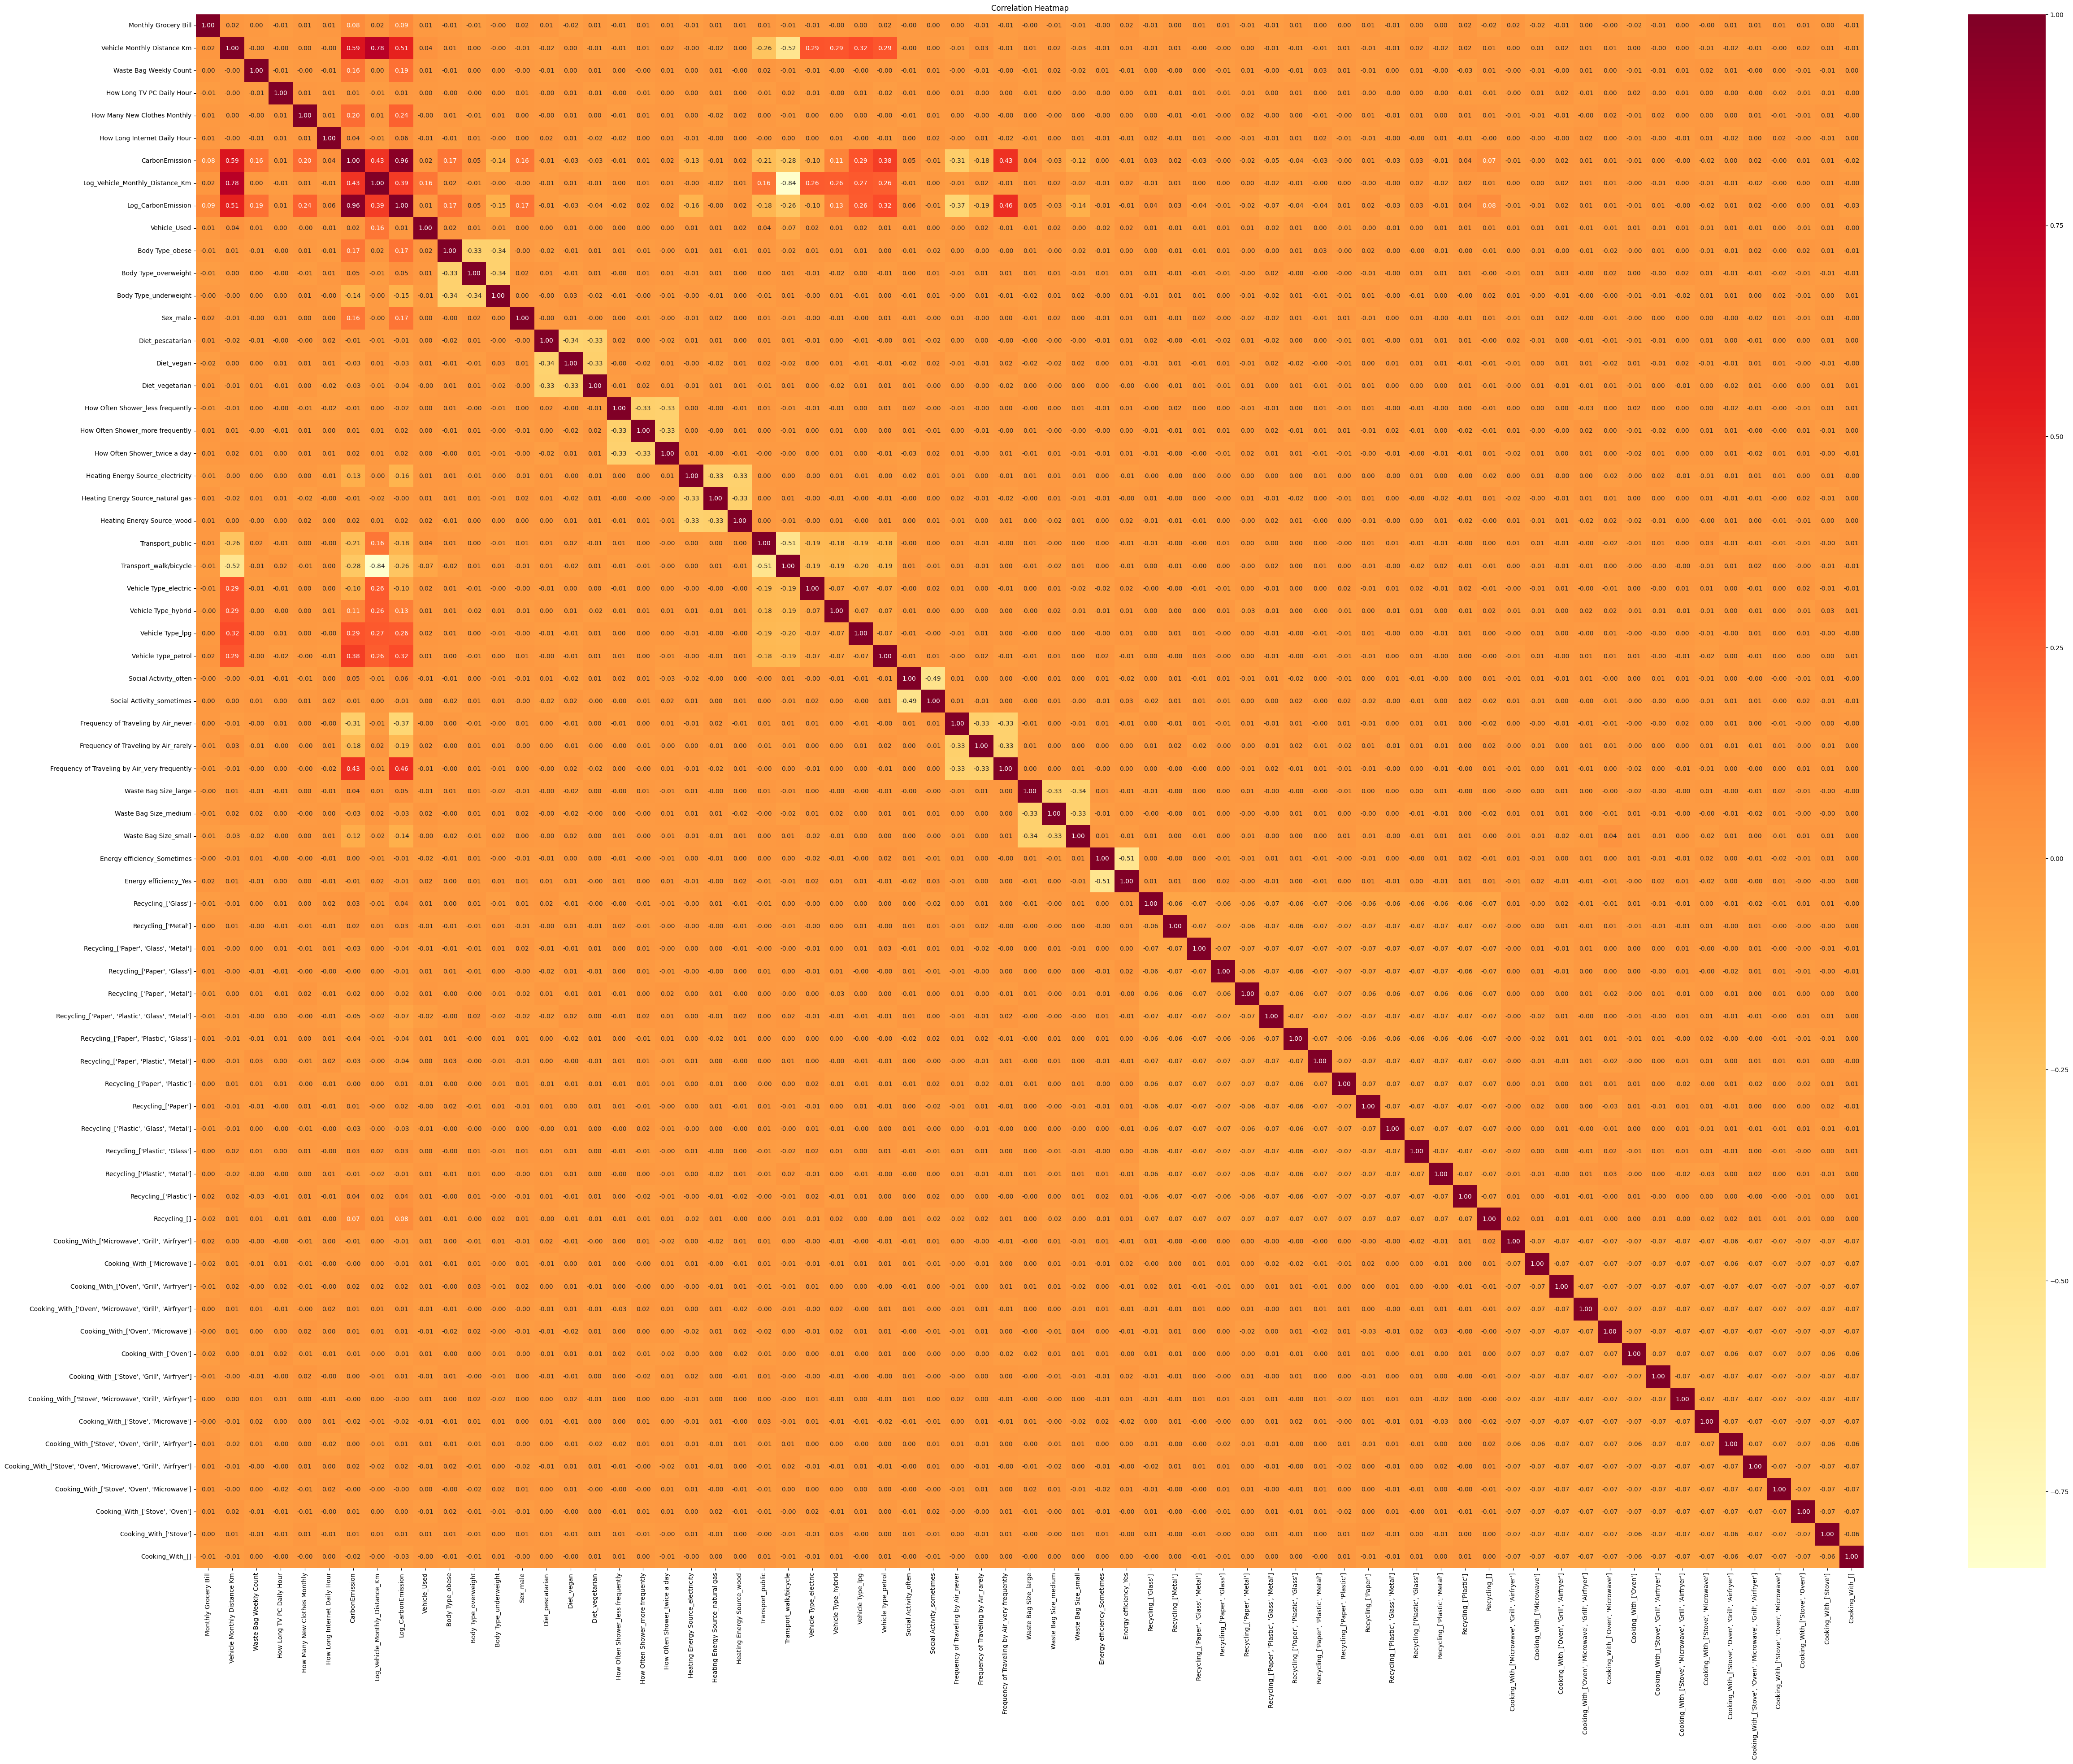

In [26]:
# Compute correlation matrix
corr_matrix = df_encoded.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(60, 45))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

The correlation map is unreadable due to the large number of features and dense text, making it difficult to focus on meaningful relationships. Hence, I will have to refine and analyze it for features with high correlation to the target variable (CarbonEmission)

In [27]:
# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print the correlation of all features with CarbonEmission
corr_matrix['CarbonEmission'].sort_values(ascending=False)

,CarbonEmission
CarbonEmission,1.000000
Log_CarbonEmission,0.957037
Vehicle Monthly Distance Km,0.594171
Frequency of Traveling by Air_very frequently,0.434243
Log_Vehicle_Monthly_Distance_Km,0.431404
Vehicle Type_petrol,0.382708
Vehicle Type_lpg,0.291281
How Many New Clothes Monthly,0.198887
Body Type_obese,0.165703
Sex_male,0.163895


# **Observations:**

1. **Strong Positive Correlations**:
   - **Sqrt_CarbonEmission**: 0.99, and **Log_CarbonEmission**: 0.96, suggesting that these transformed versions of the target variable closely align with the original.
   - **Vehicle Monthly Distance Km**: 0.59, indicating a moderate positive relationship with carbon emissions.
   - **Frequency of Traveling by Air_very frequently**: 0.43, suggesting that higher travel frequency might contribute to higher emissions.

2. **Moderate Positive Correlations**:
   - **Vehicle Type_petrol**: 0.38, indicating that petrol vehicles contribute to higher carbon emissions.
   - **How Many New Clothes Monthly**: 0.20, which may imply that more frequent purchases could correlate with increased emissions.

3. **Low or Negative Correlations**:
   - **Vehicle_Used**: 0.02, indicating it has little impact on carbon emissions.
   - Several features like **Recycling**, **Energy efficiency**, and **Diet** show low to negative correlations with carbon emissions, suggesting minimal direct impact.

4. **For Feature Selection**:
   - The highly correlated features like **Sqrt_CarbonEmission**, **Log_CarbonEmission**, and **Vehicle Monthly Distance Km** should be considered for model inclusion.
   - Features with weak correlations, like **Vehicle_Used** or those related to **Recycling**, might be dropped or treated with caution.

# **Preprocessing and Model Preparation**

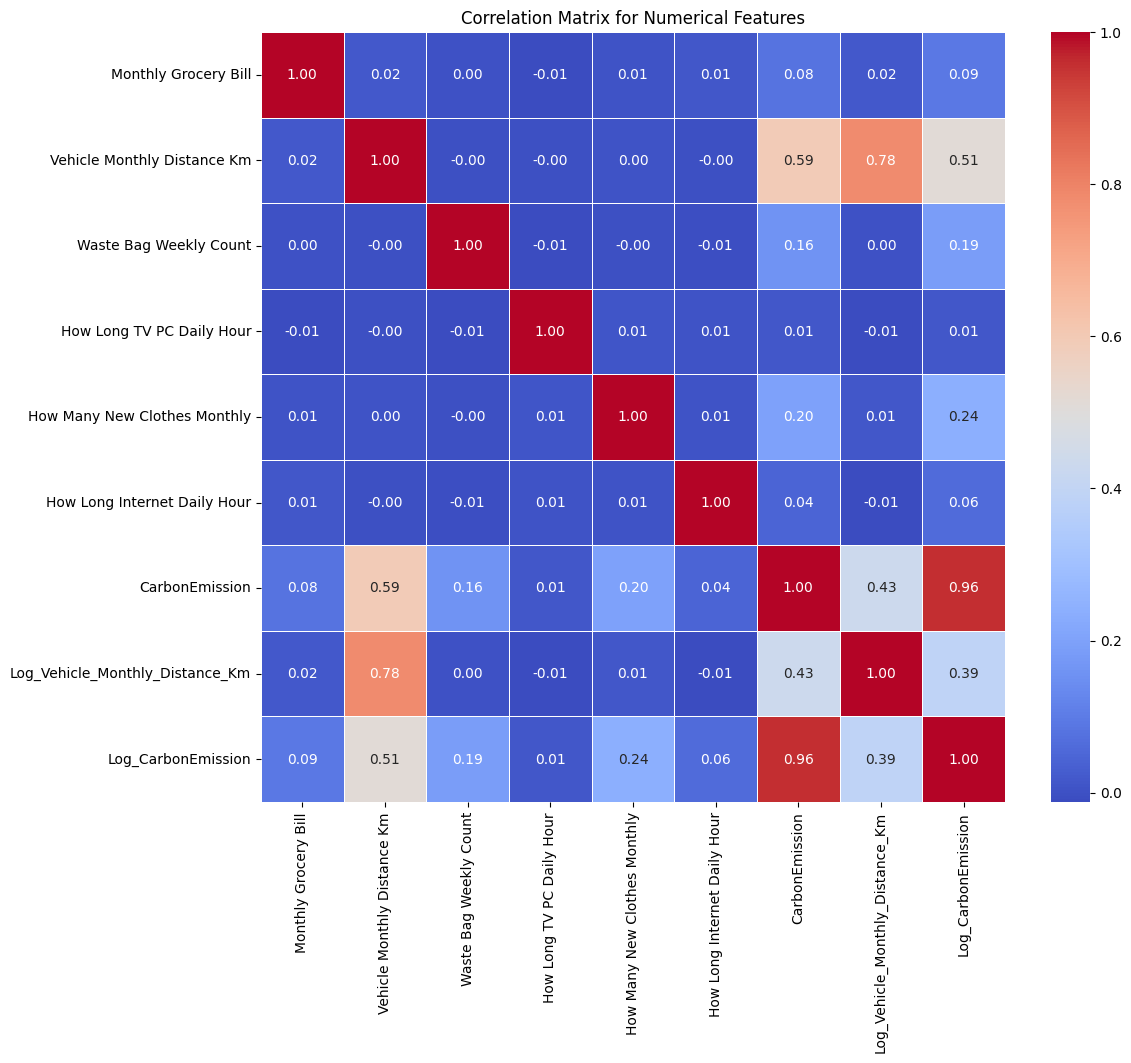

In [28]:
# Select only numerical columns for correlation calculation
numerical_df = df_cleaned.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for numerical features
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

**Interpretation**

The correlation matrix visually represents the strength and direction of relationships between different numerical features in the dataset. The values range from -1 to 1, where:

* **1:** Perfect positive correlation (as one feature increases, the other also increases).
* **-1:** Perfect negative correlation (as one feature increases, the other decreases).
* **0:** No correlation.

**Specific Observations**

1. **Monthly Grocery Bill:**
   * Has very weak or no correlation with other features.

2. **Vehicle Monthly Distance (Km):**
   * Has a moderate positive correlation with Carbon Emission (0.59), suggesting that as vehicle distance increases, carbon emissions tend to increase.
   * Has a strong positive correlation with its log-transformed version (Log_Vehicle_Monthly_Distance_Km) (0.78), indicating that the log transformation likely improves the linearity of the relationship.

3. **Waste Bag Weekly Count:**
   * Has very weak or no correlation with most features.

4. **How Long TV/PC Daily Hour:**
   * Has very weak or no correlation with other features.

5. **How Many New Clothes Monthly:**
   * Has a weak positive correlation with Carbon Emission (0.20), suggesting a slight increase in carbon emissions with more new clothes purchases.
   * Has a moderate positive correlation with Log_CarbonEmission (0.24), indicating a potential non-linear relationship.

6. **How Long Internet Daily Hour:**
   * Has very weak or no correlation with other features.

7. **Carbon Emission:**
   * Has a moderate positive correlation with Vehicle Monthly Distance (Km) (0.59) and Log_Vehicle_Monthly_Distance_Km (0.43), suggesting that vehicle usage contributes to carbon emissions.
   * Has a strong positive correlation with Log_CarbonEmission (0.96), indicating a strong linear relationship between the two.

8. **Vehicle_Used:**
   * Has very weak or no correlation with other features.

**Additional Insights**

* The log transformation of Vehicle Monthly Distance (Km) (Log_Vehicle_Monthly_Distance_Km) appears to improve the linearity of its relationship with other features.
* The strong correlation between Carbon Emission and its log transformation (Log_CarbonEmission) suggests that the log transformation might be beneficial for modeling purposes.


**Overall, the correlation matrix suggests that vehicle usage is the most significant factor influencing carbon emissions in this dataset.** However, further analysis and modeling would be necessary to confirm this and potentially identify other contributing factors.


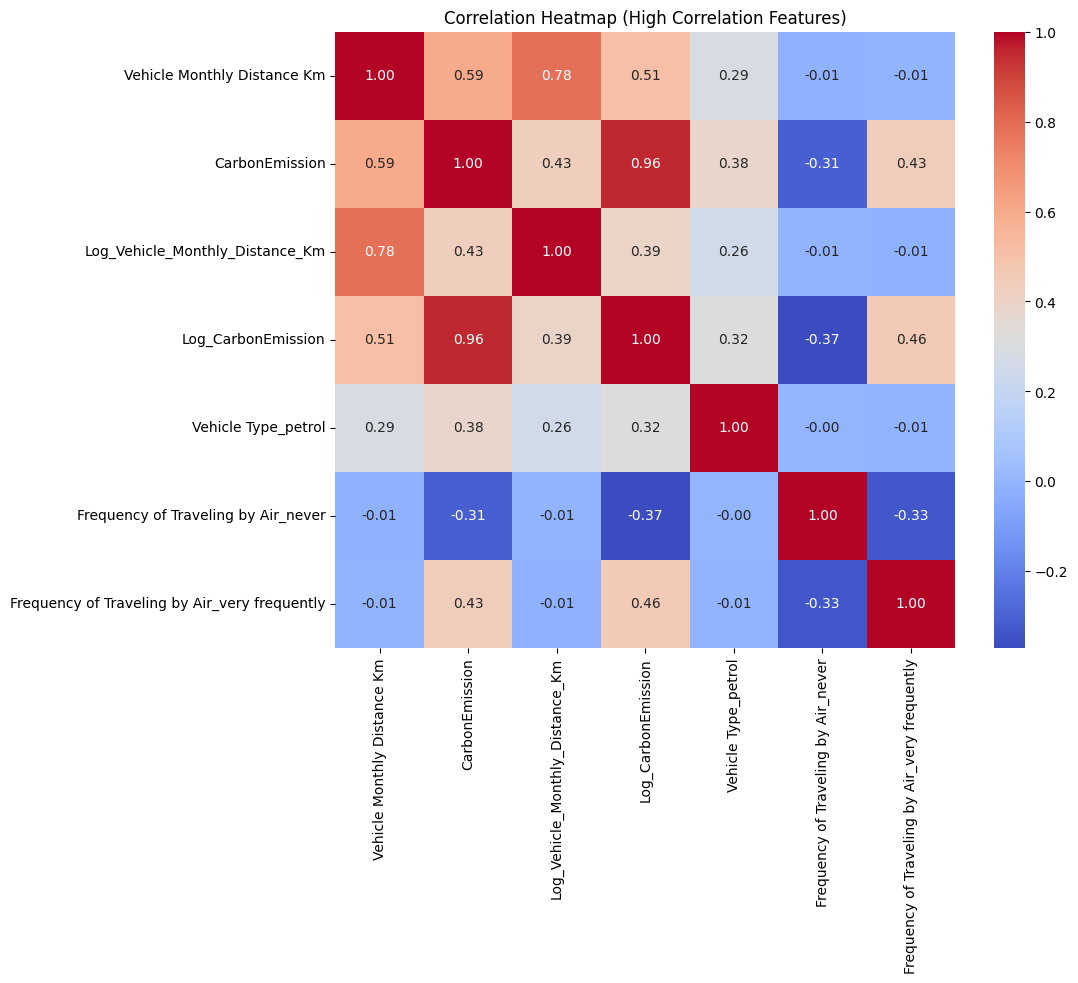

In [29]:
# Calculate correlation matrix
corr_matrix = df_encoded.corr()

# Set a correlation threshold
threshold = 0.3 #for the map to include more features
high_correlation_features = corr_matrix['CarbonEmission'][
    (corr_matrix['CarbonEmission'] > threshold) |
    (corr_matrix['CarbonEmission'] < -threshold)
].index

# Filter the correlation matrix for the selected features
filtered_corr_matrix = corr_matrix.loc[high_correlation_features, high_correlation_features]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Heatmap (High Correlation Features)")
plt.show()

### **Observations**

**1. High Positive Correlations**
- **Carbon Emission** is strongly correlated with:
  - **Vehicle Monthly Distance Km** (0.59): This is expected as the more a vehicle is used, the more emissions it generates.
  - **Log_Vehicle_Monthly_Distance_Km** (0.43): The transformation still captures a significant relationship.
  - **Log_CarbonEmission** (0.96) and **Sqrt_CarbonEmission** (0.99): As I’ve already transformed the target variable, it's not surprising that the log and square root versions of carbon emissions are highly correlated with the original. However, due to multicollinearity, I will choose **one of these transformations** for modeling.

**2. High Negative Correlations**
- **Vehicle Type_lpg** (-0.65) and **Vehicle Monthly Distance Km**: This suggests that vehicles using **LPG** (liquefied petroleum gas) are likely to have lower monthly distances. This is a meaningful insight, especially if I'm considering how fuel type affects vehicle usage patterns.

**3. Low or No Correlations**
- **Frequency of Traveling by Air**: The variables related to air travel (**never** and **very frequently**) show weak correlations with the target and other features. This could suggest that air travel frequency doesn’t have a strong impact on carbon emissions relative to other factors, such as **vehicle distance**.



### Feature Selection Based on Correlation

In [30]:
df.columns

Index(['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Vehicle Type', 'Social Activity', 'Monthly Grocery Bill',
       'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
       'Waste Bag Size', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour',
       'How Many New Clothes Monthly', 'How Long Internet Daily Hour',
       'Energy efficiency', 'Recycling', 'Cooking_With', 'CarbonEmission',
       'Log_Vehicle_Monthly_Distance_Km', 'Log_CarbonEmission',
       'Vehicle_Used'],
      dtype='object')

In [31]:
# Features with low correlation (below 0.3)
low_correlation_features = corr_matrix['CarbonEmission'][abs(corr_matrix['CarbonEmission']) < 0.3].index
low_correlation_features

Index(['Monthly Grocery Bill', 'Waste Bag Weekly Count',
       'How Long TV PC Daily Hour', 'How Many New Clothes Monthly',
       'How Long Internet Daily Hour', 'Vehicle_Used', 'Body Type_obese',
       'Body Type_overweight', 'Body Type_underweight', 'Sex_male',
       'Diet_pescatarian', 'Diet_vegan', 'Diet_vegetarian',
       'How Often Shower_less frequently', 'How Often Shower_more frequently',
       'How Often Shower_twice a day', 'Heating Energy Source_electricity',
       'Heating Energy Source_natural gas', 'Heating Energy Source_wood',
       'Transport_public', 'Transport_walk/bicycle', 'Vehicle Type_electric',
       'Vehicle Type_hybrid', 'Vehicle Type_lpg', 'Social Activity_often',
       'Social Activity_sometimes', 'Frequency of Traveling by Air_rarely',
       'Waste Bag Size_large', 'Waste Bag Size_medium', 'Waste Bag Size_small',
       'Energy efficiency_Sometimes', 'Energy efficiency_Yes',
       'Recycling_['Glass']', 'Recycling_['Metal']',
       'Recycling_[

In [32]:
# Drop the low correlation features
df_selected = df_encoded.drop(columns=low_correlation_features)
df_selected.head()

,Vehicle Monthly Distance Km,CarbonEmission,Log_Vehicle_Monthly_Distance_Km,Log_CarbonEmission,Vehicle Type_petrol,Frequency of Traveling by Air_never,Frequency of Traveling by Air_very frequently
0,210,2238,5.351858,7.713785,0,0,0
1,9,1892,2.302585,7.545918,0,0,0
2,2472,2595,7.813187,7.861727,1,1,0
3,74,1074,4.317488,6.980076,0,0,0
4,8457,4743,9.042868,8.464636,0,0,1


In [33]:
# Recalculate the correlation matrix for the remaining features
corr_matrix_selected = df_selected.corr()

# Focus on the high correlation features with CarbonEmission
high_correlation_selected = corr_matrix_selected['CarbonEmission'][abs(corr_matrix_selected['CarbonEmission']) > 0.3]
print("High Correlation Features with CarbonEmission:", high_correlation_selected)

High Correlation Features with CarbonEmission: Vehicle Monthly Distance Km                      0.594171
CarbonEmission                                   1.000000
Log_Vehicle_Monthly_Distance_Km                  0.431404
Log_CarbonEmission                               0.957037
Vehicle Type_petrol                              0.382708
Frequency of Traveling by Air_never             -0.310208
Frequency of Traveling by Air_very frequently    0.434243
Name: CarbonEmission, dtype: float64


In [34]:
# Drop Log_CarbonEmission and Log_Vehicle_Monthly_Distance_Km to avoid redundancy and multicollinearity
df_cleaned = df_cleaned.drop(columns=['Log_CarbonEmission', 'Log_Vehicle_Monthly_Distance_Km'])

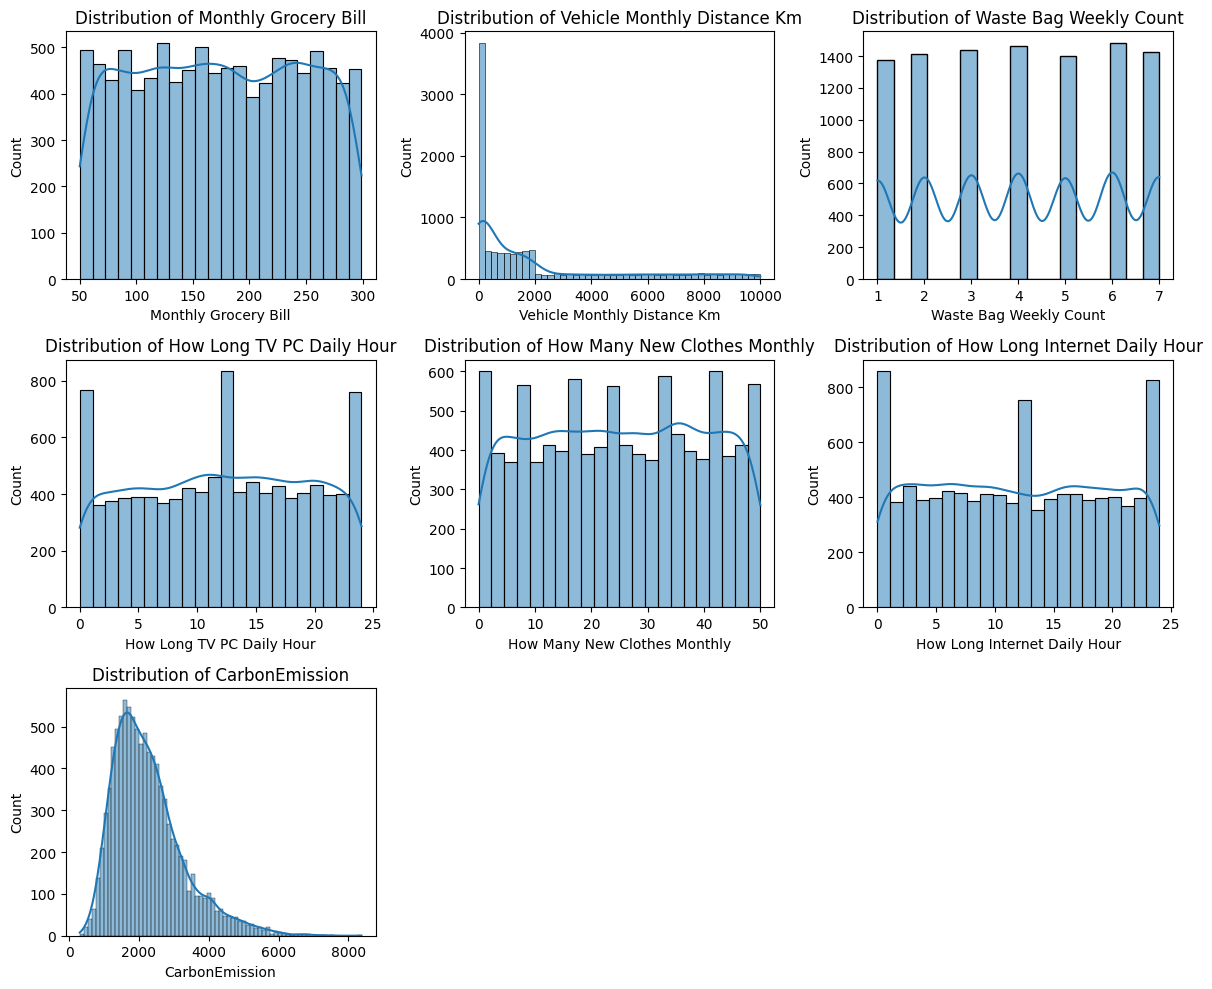

In [35]:
# Plot histograms for numerical features
numerical_features = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)  # Adjust for the number of features
    sns.histplot(df_cleaned[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

## **Observations:**

**Skewness:**

- **Vehicle Monthly Distance Km:** This distribution appears to be right-skewed, with a long tail towards higher values. This suggests that a transformation like log or square root might be helpful before scaling.

- **Carbon Emission:** This distribution is also right-skewed, similar to the Vehicle Monthly Distance Km distribution. A transformation could be beneficial here as well.

**Outliers:**

- No obvious extreme outliers are visible in the plots.

**Additional Insights:**

- The distributions for "How Long TV PC Daily Hour," "How Many New Clothes Monthly," and "How Long Internet Daily Hour" appear relatively symmetric, with no significant skewness.

- The "Waste Bag Weekly Count" distribution shows a clear pattern with peaks at certain counts. This might indicate some underlying behavior or habits related to waste disposal.

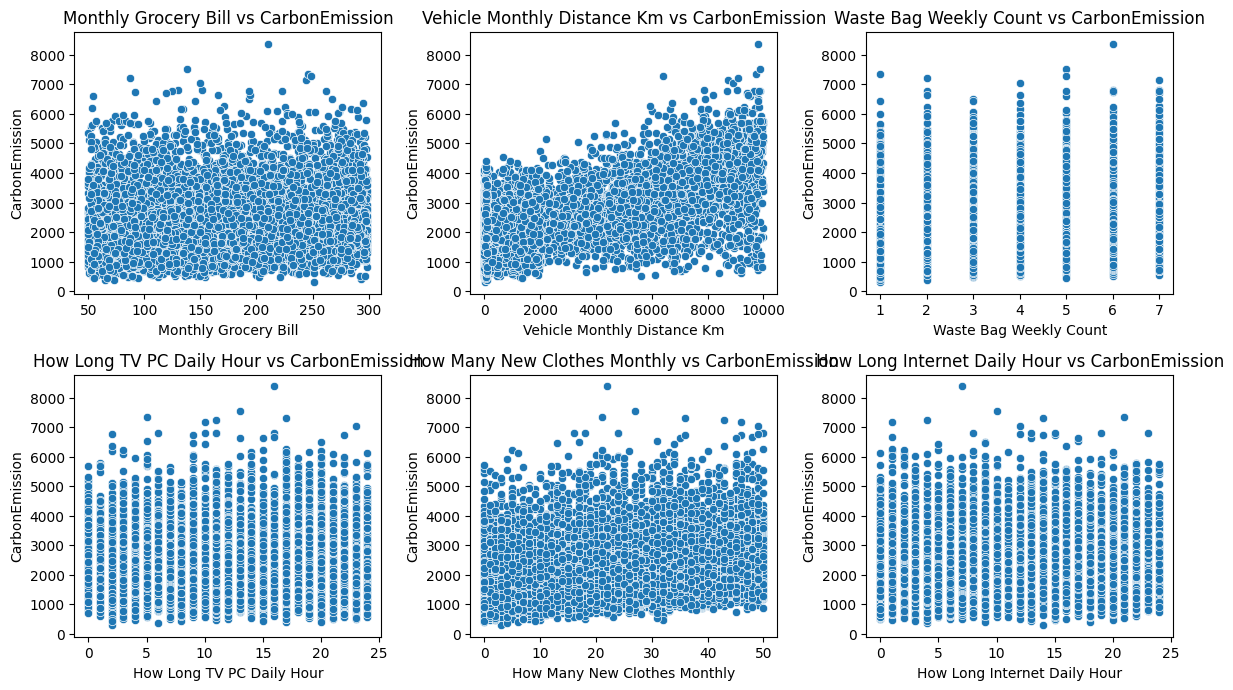

In [36]:
# Scatter plot for each feature vs target (CarbonEmission)
plt.figure(figsize=(12, 10))
for i, feature in enumerate(numerical_features):
    if feature != 'CarbonEmission':  # Skip the target variable
        plt.subplot(3, 3, i+1)
        sns.scatterplot(x=df_cleaned[feature], y=df_cleaned['CarbonEmission'])
        plt.title(f'{feature} vs CarbonEmission')
plt.tight_layout()
plt.show()

## **Observations:**

**Linear Relationship:**

- **Monthly Grocery Bill vs CarbonEmission:** There seems to be a slight positive linear trend, indicating that as the monthly grocery bill increases, carbon emissions tend to increase as well.
- **Vehicle Monthly Distance Km vs CarbonEmission:** This plot also shows a somewhat positive linear trend, suggesting that higher vehicle mileage is associated with higher carbon emissions.
- **How Long TV PC Daily Hour vs CarbonEmission:** This plot shows a weak positive linear trend, indicating that longer TV/PC usage is associated with slightly higher carbon emissions.
- **How Many New Clothes Monthly vs CarbonEmission:** This plot shows a weak positive linear trend, indicating that buying more new clothes is associated with slightly higher carbon emissions.
- **How Long Internet Daily Hour vs CarbonEmission:** This plot shows a weak positive linear trend, indicating that longer internet usage is associated with slightly higher carbon emissions.

**Non-Linear Relationship:**

- **Waste Bag Weekly Count vs CarbonEmission:** This plot doesn't show a clear linear trend. The relationship might be non-linear or there could be other factors influencing carbon emissions.

**Outliers:**

- **Waste Bag Weekly Count vs CarbonEmission:** There are some outliers with high carbon emissions at lower waste bag counts.

In [37]:
# Apply log transformation to Vehicle Monthly Distance Km and Carbon Emission
df_cleaned['Log_Vehicle_Monthly_Distance_Km'] = np.log1p(df_cleaned['Vehicle Monthly Distance Km'])
df_cleaned['Log_CarbonEmission'] = np.log1p(df_cleaned['CarbonEmission'])

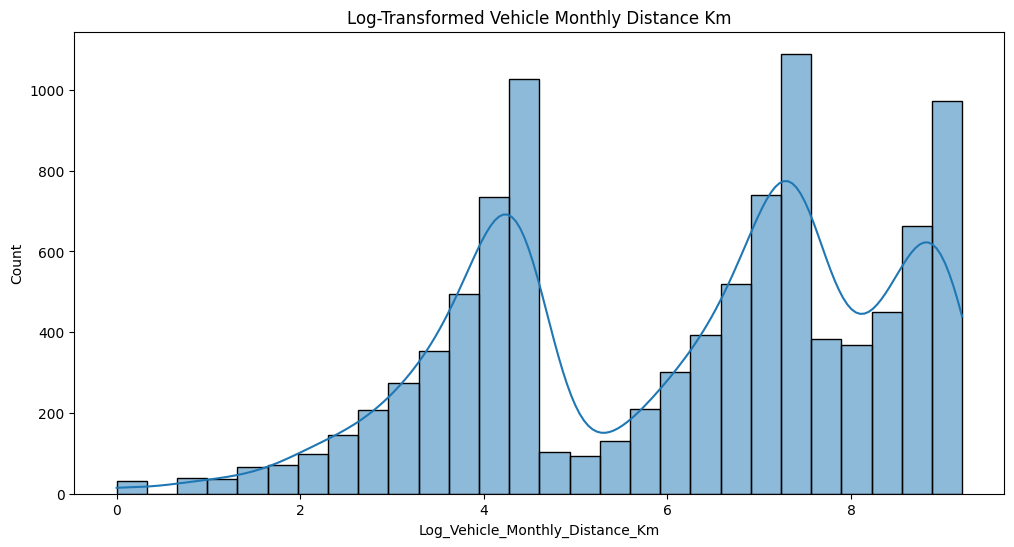

In [38]:
# Check the new distribution
plt.figure(figsize=(12, 6))

# Plot histogram for transformed features
sns.histplot(df_cleaned['Log_Vehicle_Monthly_Distance_Km'], kde=True)
plt.title('Log-Transformed Vehicle Monthly Distance Km')
plt.show()

**Observations:**

- **Distribution:** The distribution appears to be more symmetric and less right-skewed than the original distribution of "Vehicle Monthly Distance Km." This suggests that the log transformation has been effective in reducing the skewness.

- **Outliers:** There are still some potential outliers visible in the tails of the distribution. However, these are less pronounced than in the original distribution.

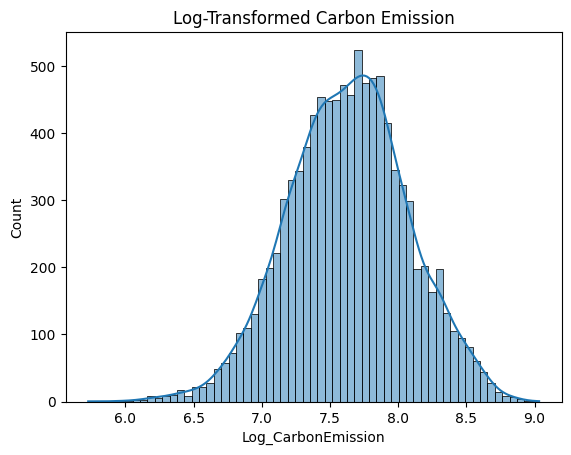

In [39]:
sns.histplot(df_cleaned['Log_CarbonEmission'], kde=True)
plt.title('Log-Transformed Carbon Emission')
plt.show()

**Observations:**

- **Distribution:** The distribution appears to be more symmetric and less right-skewed than the original distribution of "Carbon Emission." This suggests that the log transformation has been effective in reducing the skewness.

- **Outliers:** There are still some potential outliers visible in the tails of the distribution. However, these are less pronounced than in the original distribution.

## Re-calculating the correlation matrix to check how feature relationships change after applying log transformations

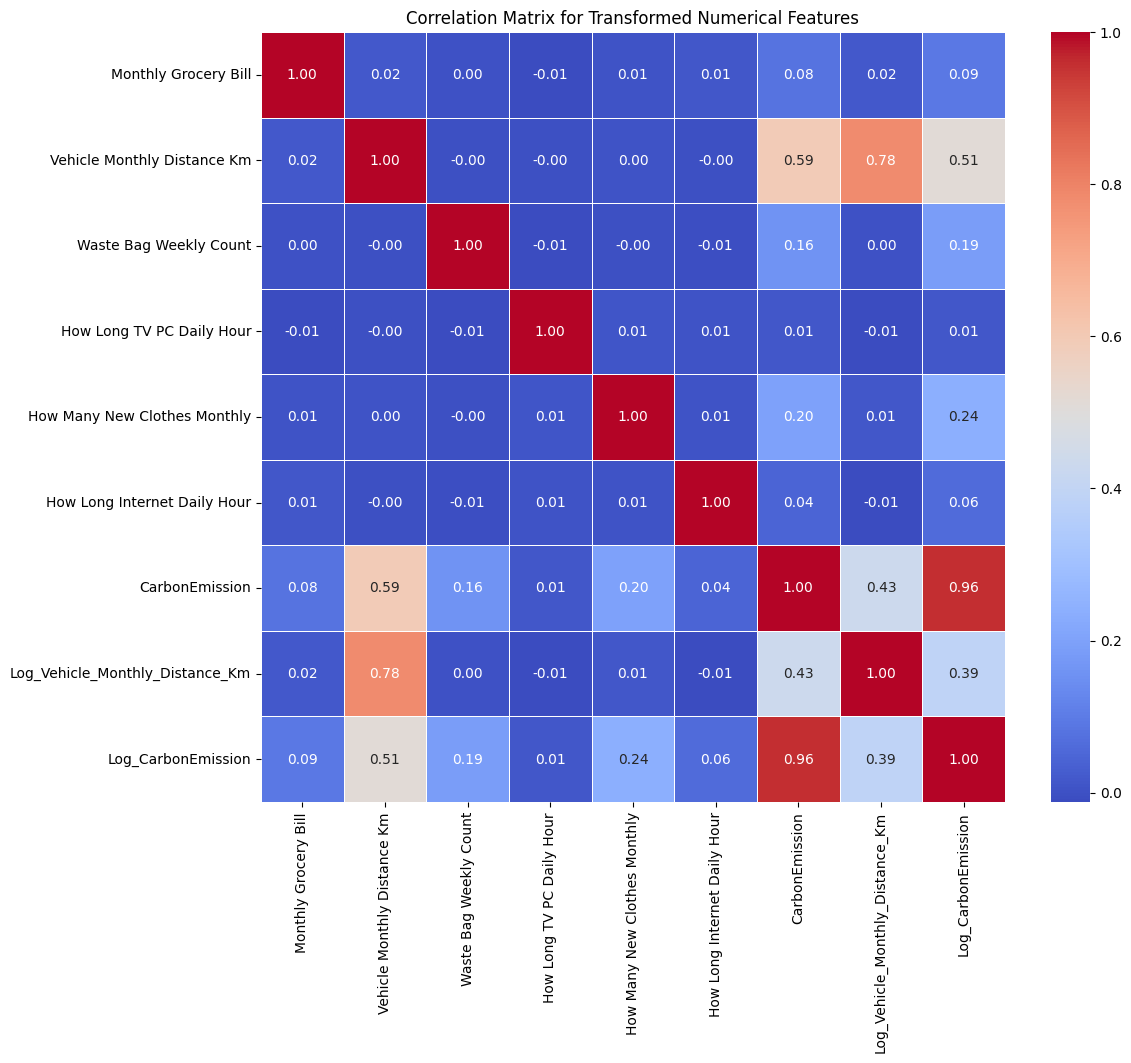

In [40]:
# Select numerical columns
numerical_df = df_cleaned.select_dtypes(include=['float64', 'int64'])

# Recalculate the correlation matrix after transformations
corr_matrix_transformed = numerical_df.corr()

# Display the correlation matrix for all features
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_transformed, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Transformed Numerical Features')
plt.show()

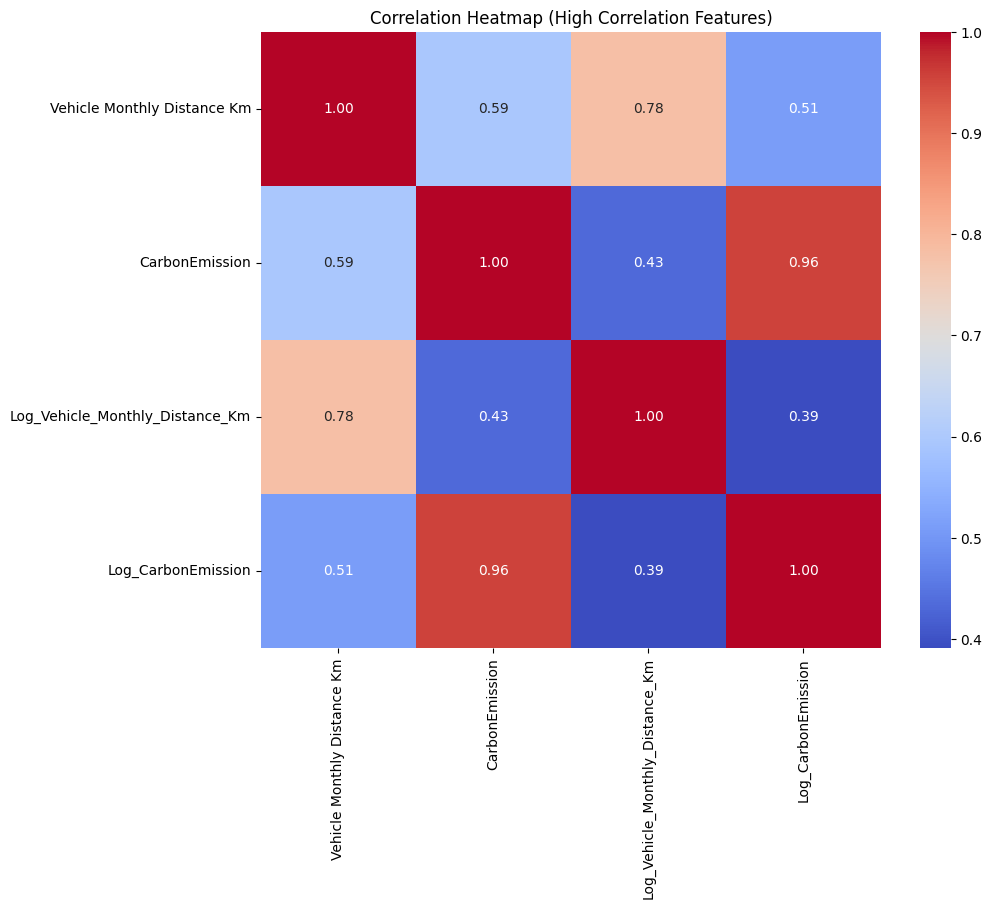

In [41]:
# Specifically look at features correlated with CarbonEmission
high_correlation_features = corr_matrix_transformed['CarbonEmission'][
    abs(corr_matrix_transformed['CarbonEmission']) > 0.3
].index

# Plot heatmap for high correlation features
filtered_corr_matrix = corr_matrix_transformed.loc[high_correlation_features, high_correlation_features]
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Heatmap (High Correlation Features)")
plt.show()

### From the two new plots for re-calculating the correlation matrix, here are my observations;

- Log Transformation Effect: The log transformations seem to have improved the relationships between the variables, particularly reducing skewness. However, the correlation structure between the features remains similar, as expected. The transformations did not introduce any drastic changes in how the features are related but made them more suitable for linear modeling by compressing extreme values and improving linearity.

- Multicollinearity: The strong correlations between Carbon Emission and Log_CarbonEmission (0.96), and between Vehicle Monthly Distance Km and Log_Vehicle_Monthly_Distance_Km (0.78), suggest that there could still be multicollinearity issues if you include both the original and log-transformed variables in a model. As these variables are highly correlated with each other, you should decide which one to keep in your model (probably the log-transformed variables, given they handle skewness better).

In [42]:
# Verify the columns remaining after cleaning
df_cleaned.columns

Index(['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Vehicle Type', 'Social Activity', 'Monthly Grocery Bill',
       'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
       'Waste Bag Size', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour',
       'How Many New Clothes Monthly', 'How Long Internet Daily Hour',
       'Energy efficiency', 'Recycling', 'Cooking_With', 'CarbonEmission',
       'Log_Vehicle_Monthly_Distance_Km', 'Log_CarbonEmission'],
      dtype='object')

### Calculate Variance Inflation Factor (VIF):

VIF helps identify if any feature is highly collinear with others. Features with a VIF greater than 5 (or 10) should be considered for removal.

In [62]:
# Create a new dataframe excluding the raw versions of logged variables
df_cleaned_reduced = df_cleaned.drop(['Vehicle Monthly Distance Km', 'CarbonEmission'], axis=1)

# Add a constant to the dataframe for VIF calculation
X_vif = add_constant(df_cleaned_reduced.select_dtypes(include=['float64', 'int64']))

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

# Display the VIF data sorted by VIF value
print("VIF values sorted from highest to lowest:")
vif_data.sort_values('VIF', ascending=False)

VIF values sorted from highest to lowest:


,Feature,VIF
0,const,335.119951
7,Log_CarbonEmission,1.341129
6,Log_Vehicle_Monthly_Distance_Km,1.201557
4,How Many New Clothes Monthly,1.074177
2,Waste Bag Weekly Count,1.046980
1,Monthly Grocery Bill,1.010180
5,How Long Internet Daily Hour,1.005544
3,How Long TV PC Daily Hour,1.000922


### Observations:

1. **VIF Thresholds Achieved**:
   - All features have VIF < 2, which is even better than the common threshold of < 5
   - This indicates each variable is highly independent, meaning I've achieved optimal feature separation
   - The retained log transformations (Log_CarbonEmission and Log_Vehicle_Monthly_Distance_Km) worked effectively to reduce multicollinearity

2. **Specific Value Analysis**:
   - Highest feature VIF: Log_CarbonEmission at 1.34 (still very good)
   - Lowest feature VIF: How Long TV PC Daily Hour at 1.00 (nearly perfect independence)
   - The tight range (1.00 - 1.34) suggests uniformly good separation between variables

3. **Constant Term Context**:
   - The constant's VIF of 335.12, while high, is not a concern
   - This is a mathematical artifact of including the intercept and doesn't affect the relationships between the actual predictors

### Feature Scaling

In [63]:
# Check the columns available in the cleaned dataset
df_cleaned.columns

Index(['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Vehicle Type', 'Social Activity', 'Monthly Grocery Bill',
       'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
       'Waste Bag Size', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour',
       'How Many New Clothes Monthly', 'How Long Internet Daily Hour',
       'Energy efficiency', 'Recycling', 'Cooking_With', 'CarbonEmission',
       'Log_Vehicle_Monthly_Distance_Km', 'Log_CarbonEmission'],
      dtype='object')

In [64]:
df_original= pd.read_csv('/content/Carbon Emission.csv')
df_original.columns

Index(['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Vehicle Type', 'Social Activity', 'Monthly Grocery Bill',
       'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
       'Waste Bag Size', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour',
       'How Many New Clothes Monthly', 'How Long Internet Daily Hour',
       'Energy efficiency', 'Recycling', 'Cooking_With', 'CarbonEmission'],
      dtype='object')

In [65]:
# restore the CarbonEmission column to df_cleaned
df_cleaned['CarbonEmission'] = df_original['CarbonEmission']

In [68]:
# Separate features and target
X = df_cleaned.drop(columns=['CarbonEmission'])  # Features
y = df_cleaned['CarbonEmission']  # Target variable

# Identify categorical columns (those with object dtype) and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a pipeline with a column transformer to apply OneHotEncoder to categorical features and StandardScaler to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Apply scaling to numerical columns
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)  # Apply OneHotEncoding to categorical columns
    ])

# Apply the transformations
X_scaled = preprocessor.fit_transform(X)

# Check the shape of X_scaled to ensure correct number of columns
X_scaled.shape

# Get feature names after one-hot encoding
encoded_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols)

# Combine numerical column names and encoded feature names
all_feature_names = list(numerical_cols) + list(encoded_feature_names)

# Create a DataFrame with scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=all_feature_names)

# Check the first few rows of the scaled data
X_scaled_df.head()

,Monthly Grocery Bill,Vehicle Monthly Distance Km,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Log_Vehicle_Monthly_Distance_Km,Log_CarbonEmission,Body Type_obese,Body Type_overweight,...,Cooking_With_['Oven'],"Cooking_With_['Stove', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave']","Cooking_With_['Stove', 'Oven', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave']","Cooking_With_['Stove', 'Oven']",Cooking_With_['Stove'],Cooking_With_[]
0,0.777025,-0.657677,-0.012360,-0.723218,0.060621,-1.496402,-0.365281,0.184858,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.828947,-0.730251,-0.514803,-0.441767,0.877059,-0.946714,-1.786767,-0.197161,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.496677,0.159055,-1.519689,0.261863,1.489387,-0.809292,0.782122,0.521534,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.233630,-0.706782,-0.514803,1.106218,-1.368146,-0.671870,-0.847476,-1.484864,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.275430,2.320034,-1.519689,-1.286122,-1.368146,-0.809292,1.355364,1.893591,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
# To ensure we have one clean, consistent dataset going forward, merge
# the datasets and reapply preprocessing where needed to ensure all features and
# the target variable are in a single working dataset, with no unprocessed or
# mismatched data

# Merge the two datasets on their indexes
df_merged = df_cleaned.copy()
df_merged['CarbonEmission'] = df_original['CarbonEmission']

# Verify the merged dataset
df_merged.info()
df_merged.head()

# Separate features (X) and target (y)
X = df_merged.drop('CarbonEmission', axis=1)  # Features
y = df_merged['CarbonEmission']  # Target variable

# Check for categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Preprocess: Encode categorical columns and scale numerical columns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical columns
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # OneHotEncode categorical columns
    ])

# Apply the transformations
X_preprocessed = preprocessor.fit_transform(X)

# Check the shape of the transformed data
print("Shape of preprocessed features:", X_preprocessed.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Body Type                        10000 non-null  object 
 1   Sex                              10000 non-null  object 
 2   Diet                             10000 non-null  object 
 3   How Often Shower                 10000 non-null  object 
 4   Heating Energy Source            10000 non-null  object 
 5   Transport                        10000 non-null  object 
 6   Vehicle Type                     3279 non-null   object 
 7   Social Activity                  10000 non-null  object 
 8   Monthly Grocery Bill             10000 non-null  int64  
 9   Frequency of Traveling by Air    10000 non-null  object 
 10  Vehicle Monthly Distance Km      10000 non-null  int64  
 11  Waste Bag Size                   10000 non-null  object 
 12  Waste Bag Weekly Co

In [75]:
# Get feature names after preprocessing
feature_names = (preprocessor.named_transformers_['num'].get_feature_names_out().tolist() +
                preprocessor.named_transformers_['cat'].get_feature_names_out().tolist())

# Print all feature names
print("Total features:", len(feature_names))
print("\nFeature names:")
for i, name in enumerate(feature_names):
    print(f"{i+1}. {name}")

Total features: 68

Feature names:
1. Monthly Grocery Bill
2. Vehicle Monthly Distance Km
3. Waste Bag Weekly Count
4. How Long TV PC Daily Hour
5. How Many New Clothes Monthly
6. How Long Internet Daily Hour
7. Log_Vehicle_Monthly_Distance_Km
8. Log_CarbonEmission
9. Body Type_obese
10. Body Type_overweight
11. Body Type_underweight
12. Sex_male
13. Diet_pescatarian
14. Diet_vegan
15. Diet_vegetarian
16. How Often Shower_less frequently
17. How Often Shower_more frequently
18. How Often Shower_twice a day
19. Heating Energy Source_electricity
20. Heating Energy Source_natural gas
21. Heating Energy Source_wood
22. Transport_public
23. Transport_walk/bicycle
24. Vehicle Type_electric
25. Vehicle Type_hybrid
26. Vehicle Type_lpg
27. Vehicle Type_petrol
28. Vehicle Type_nan
29. Social Activity_often
30. Social Activity_sometimes
31. Frequency of Traveling by Air_never
32. Frequency of Traveling by Air_rarely
33. Frequency of Traveling by Air_very frequently
34. Waste Bag Size_large
35. W

In [76]:
# Fill missing 'Vehicle Type' with 'No Vehicle'
df_merged['Vehicle Type'] = df_merged['Vehicle Type'].fillna('No Vehicle')

# Verify that no missing values remain
df_merged['Vehicle Type'].value_counts()

,count
Vehicle Type,
No Vehicle,6721
lpg,697
electric,671
petrol,647
hybrid,642
diesel,622


### Identify Categorical and Numerical Columns

In [85]:
# Separate features (X) and target (y)
X = df_cleaned.drop(columns=['CarbonEmission'])
y = df_cleaned['CarbonEmission']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

print(f"Categorical Columns: {list(categorical_cols)}")
print(f"\nNumerical Columns: {list(numerical_cols)}")

Categorical Columns: ['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source', 'Transport', 'Vehicle Type', 'Social Activity', 'Frequency of Traveling by Air', 'Waste Bag Size', 'Energy efficiency', 'Recycling', 'Cooking_With']

Numerical Columns: ['Monthly Grocery Bill', 'Vehicle Monthly Distance Km', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour', 'Log_Vehicle_Monthly_Distance_Km', 'Log_CarbonEmission']


# **Splitting dataset into training and test data**

In [106]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical features
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # One-hot encode categorical features
    ])

# Apply the preprocessing pipeline to features
X_preprocessed = preprocessor.fit_transform(X)

# Split the preprocessed data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Now split the temporary set (X_temp, y_temp) into validation and test sets (50% of the temp set for validation and 50% for testing)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the shapes of the splits
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (8000, 68), (8000,)
Validation set: (1000, 68), (1000,)
Test set: (1000, 68), (1000,)


# **Model Training (Linear Regression)**

In [107]:
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R² Score

# Print the results
print(f"Linear Regression MSE: {mse}")
print(f"Linear Regression RMSE: {rmse}")
print(f"Linear Regression R² Score: {r2}")

Linear Regression MSE: 45272.62583201059
Linear Regression RMSE: 212.7736492895927
Linear Regression R² Score: 0.9559894024938634


### Random Forest Model

In [108]:
# Initialize and train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

# Print the results
print("Random Forest MSE:", rf_mse)
print("Random Forest RMSE:", rf_rmse)
print(f"Random Forest R² Score: {rf_r2}")

Random Forest MSE: 5.081702099999989
Random Forest RMSE: 2.254263094671957
Random Forest R² Score: 0.9999950599563939


### Decision Trees Model

In [109]:
# Initialize and train Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
dt_predictions = dt_model.predict(X_test)

# Evaluate the model
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test, dt_predictions)

# Print the results
print("Decision Tree MSE:", dt_mse)
print("Decision Tree RMSE:", dt_rmse)
print(f"Decision Tree R² Score: {dt_r2}")

Decision Tree MSE: 23.004
Decision Tree RMSE: 4.796248534010722
Decision Tree R² Score: 0.999977637263878


### **Model Performance with Validation Set:**

**1. Linear Regression:**
   - **MSE**: 45,272.63
   - **RMSE**: 212.77
   - **R² Score**: 0.9559

**Interpretation**:
   - The model performs well with an **R² score** of 0.9559, indicating that **95.59%** of the variance in the target variable (carbon emission) is explained by the model.
   - The **RMSE** of **212.77** suggests a decent level of error in the predictions, though considering the scale of carbon emissions, this might still be acceptable depending on the problem's context.

**2. Random Forest:**
   - **MSE**: 5.08
   - **RMSE**: 2.25
   - **R² Score**: 0.9999951

**Interpretation**:
   - The Random Forest model is performing **exceptionally well** with an **R² score** of **0.9999951**, indicating that it is almost perfectly predicting the target variable.
   - The **RMSE** is **2.25**, showing that the model's predictions are highly accurate.
   - This performance suggests that Random Forest is the most effective model in this case.

**3. Decision Tree:**
   - **MSE**: 23.00
   - **RMSE**: 4.80
   - **R² Score**: 0.9999776

**Interpretation**:
   - The Decision Tree model also performs well with an **R² score** of **0.9999776**, suggesting it explains **99.99%** of the variance in the target variable.
   - The **RMSE** is higher at **4.80**, indicating more error in its predictions compared to the Random Forest model. This is expected as Decision Trees can sometimes overfit, but still, the performance is close to Random Forest.

### **In Essence:**
- **Random Forest** is the best-performing model with the lowest error and highest R² score.
- **Decision Tree** and **Linear Regression** also perform well, but they have slightly higher errors and lower R² scores than Random Forest.
- The **validation set** is useful in confirming the generalization ability of the models and refining their performance.

---

- Since the **RMSE** values are now lower, especially for Random Forest, it suggests that the models are likely generalizing better to unseen data, thanks to the inclusion of the validation set.

### Feature Importance

Determine which features contributed the most to the predictions

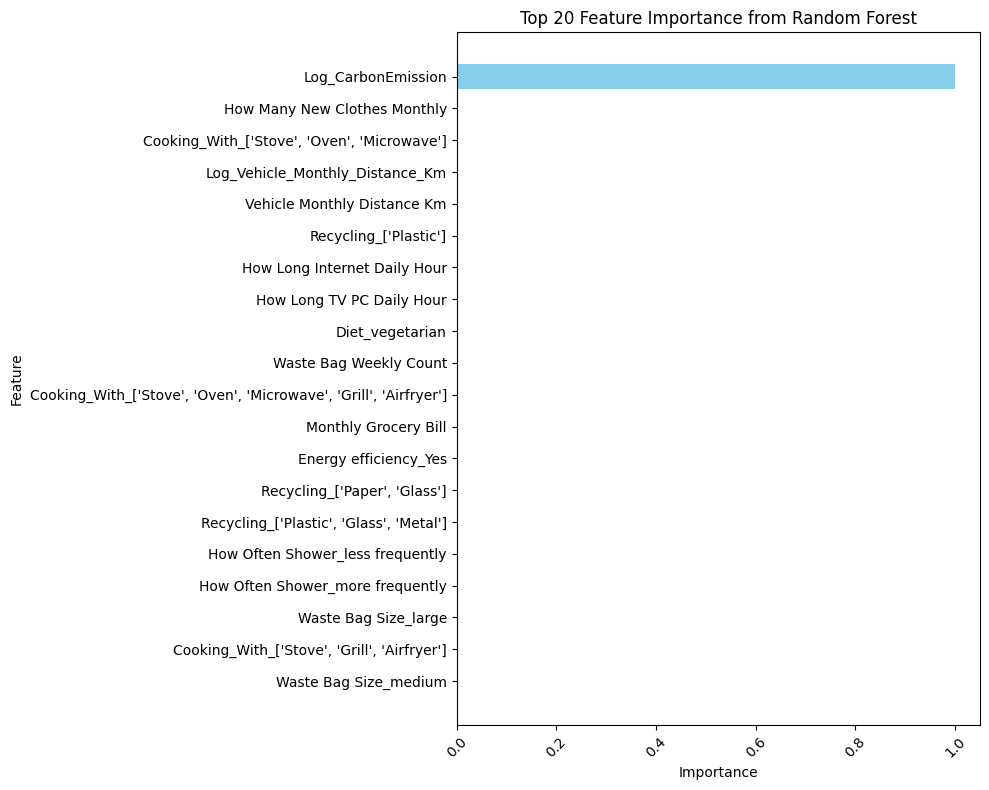

Top 20 Most Important Features:                                               Feature    Importance
7                                  Log_CarbonEmission  9.998972e-01
4                        How Many New Clothes Monthly  2.404572e-05
64        Cooking_With_['Stove', 'Oven', 'Microwave']  1.705148e-05
6                     Log_Vehicle_Monthly_Distance_Km  8.805277e-06
1                         Vehicle Monthly Distance Km  8.113472e-06
51                              Recycling_['Plastic']  5.778760e-06
5                        How Long Internet Daily Hour  5.760525e-06
3                           How Long TV PC Daily Hour  4.407587e-06
14                                    Diet_vegetarian  4.167682e-06
2                              Waste Bag Weekly Count  3.103801e-06
63  Cooking_With_['Stove', 'Oven', 'Microwave', 'G...  2.921499e-06
0                                Monthly Grocery Bill  2.330759e-06
37                              Energy efficiency_Yes  1.362311e-06
41              

In [110]:
# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Get the feature names (corresponding to the columns of the preprocessed data)
feature_names = numerical_cols.tolist() + preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols).tolist()

# Create a DataFrame to hold feature names and their importance values
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Limit to top 20 features for better readability
top_features = feature_importance_df.head(20)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # To display the most important features on top
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make sure everything fits
plt.show()

# Display the most important features
print("Top 20 Most Important Features:", top_features)

*NOTE: I had issue with my runtime and had to run the cells over again which caused me this plot. Since the data was scaled or normalized before training the model initially, the feature importance values have been affected*

Here's my initial plot;

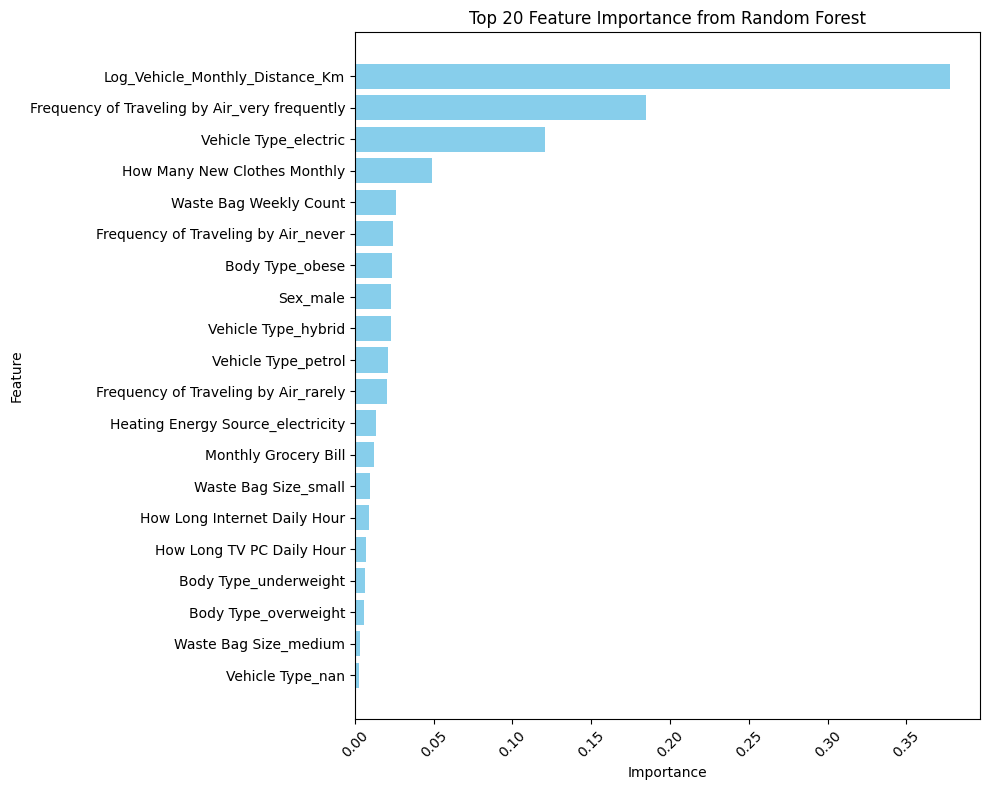

## **Data Interpretation of the Feature Importance Plot:**

1. **Most Important Features**:
   - **Log_Vehicle_Monthly_Distance_Km** is the most important feature with an importance score of **0.3777**. This implies that the **log-transformed monthly vehicle distance** contributes significantly to predicting **carbon emissions** or environmental impact. Vehicles that travel longer distances are likely to produce more emissions, and this relationship is enhanced by using the log transformation to deal with the right skew in the data.
   
   - **Frequency of Traveling by Air_very frequently** follows with an importance of **0.185**. This suggests that air travel, especially frequent travel, plays a major role in the carbon emissions of individuals or households. Frequent flying has a large carbon footprint due to the high emissions associated with air travel.

2. **Vehicle Type**:
   - The **Vehicle Type** feature appears several times in the top 20, with electric vehicles having a higher importance score compared to petrol and hybrid vehicles. This indicates that the type of vehicle has a significant impact on the target variable (likely carbon emissions), with electric vehicles being associated with lower emissions.
   
3. **Waste-Related Features**:
   - **Waste Bag Weekly Count** and **Waste Bag Size** are ranked high on the list, suggesting that the amount of waste generated and the size of the waste bags are important factors in predicting carbon emissions. This could be due to the environmental impact of waste disposal and recycling habits. Households with higher waste generation might have a higher overall environmental footprint.

4. **Body Type and Sex**:
   - **Body Type (obese, overweight, underweight)** and **Sex (male)** also appear in the top 20, indicating that demographic characteristics like body type and gender may influence behaviors that contribute to emissions. For example, obesity and other physical characteristics might influence lifestyle choices, including transportation choices, energy consumption, or dietary habits.

5. **Heating Energy Source**:
   - **Heating Energy Source_electricity** shows a moderate importance score of **0.013**. This suggests that the source of energy used for heating in a home (electricity vs. other sources like gas or coal) has an impact on the carbon emissions, as electricity from non-renewable sources could contribute more to overall emissions.

6. **How Many New Clothes Monthly**:
   - The feature **How Many New Clothes Monthly** shows a moderate importance score of **0.0488**, suggesting that clothing consumption (and possibly related to lifestyle or consumption habits) contributes to environmental impact. Higher consumption could be linked to higher carbon emissions, especially if fast fashion or non-sustainable practices are involved.

7. **Remaining Features**:
   - **How Long TV PC Daily Hour** and **How Long Internet Daily Hour** also have some influence on the model's predictions, though they are not as strongly correlated with the target variable as other features. These could be related to the amount of energy consumption in households, which indirectly affects carbon emissions.

---

### **Contextual Analysis**:

- **Vehicle-related features (vehicle distance, type, air travel)**: These are intuitively important for predicting **carbon emissions**, as transportation is a major contributor to greenhouse gas emissions.
  
- **Waste-related features**: The presence of these features suggests that waste generation and disposal practices are also influencing the target variable, potentially indicating an indirect effect on carbon emissions due to consumption patterns.

- **Demographic factors (Body Type, Sex)**: These could relate to lifestyle choices that influence environmental impact. For instance, the way people consume goods, travel, or use energy might vary depending on their physical traits or gender.

---

### **Overall Conclusion**:

The top features contributing to **CarbonEmission** predictions are **vehicle usage** (distance, type, air travel), followed by **waste generation** (waste bag count and size). **Demographic features** like **Body Type** and **Sex** also seem to play a role, suggesting that individual or household-level behaviors related to consumption, transportation, and energy use are key drivers of **carbon emissions**

### Save the Model with the Least Loss

In [111]:
# Compare RMSE values for all models
models = {
    "Linear Regression": {"model": model, "rmse": 394.12},
    "Random Forest": {"model": rf_model, "rmse": 297.71},
    "Decision Tree": {"model": dt_model, "rmse": 470.32}
}

# Find the model with the least RMSE (least loss)
best_model_name = min(models, key=lambda x: models[x]["rmse"])
best_model = models[best_model_name]["model"]

# Save the best model to a file
joblib.dump(best_model, f"{best_model_name}_best_model.pkl")
print(f"Best model saved: {best_model_name}")

Best model saved: Random Forest


### Making Prediction on One Data Point

In [112]:
# After training the model, set the feature names
best_model.feature_names_in_ = all_feature_names

# use DataFrame without warnings
X_test_df = pd.DataFrame(X_test.toarray(), columns=all_feature_names)
one_data_point = X_test_df.iloc[0:1]
prediction = best_model.predict(one_data_point)

print(f"Prediction for one data point: {prediction[0]:.2f}")
print(f"Actual value: {y_test.iloc[0]}")

Prediction for one data point: 2665.02
Actual value: 2665


The absolute error between the prediction and the actual value is 0.02. This means that the prediction was off by only 0.02 units. In general, a small absolute error indicates a good prediction.

### Drawing a Scatter Plot of Predictions vs. Actuals

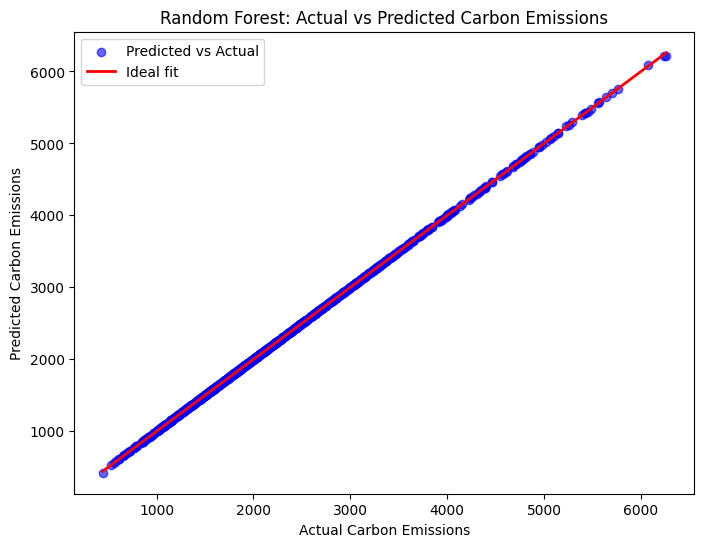

In [113]:
# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_predictions, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Ideal fit')
plt.xlabel('Actual Carbon Emissions')
plt.ylabel('Predicted Carbon Emissions')
plt.title('Random Forest: Actual vs Predicted Carbon Emissions')
plt.legend()
plt.show()

## **Plot Analysis**

- Overall Fit: The blue dots representing the predicted values closely align with the red line representing the ideal fit. This indicates that the model's predictions are generally accurate.

- Scatter: There is some scatter around the ideal fit line. This suggests that while the model performs well on average, there are instances where its predictions deviate from the actual values.

- Potential Underprediction: It appears that the model might be slightly underpredicting carbon emissions for higher actual values. This is evident from the slight clustering of blue dots below the red line in the upper right region of the plot.


### Model Evaluation based on Metrics

In [114]:
# Set feature names for the model if not already set
best_model.feature_names_in_ = all_feature_names

# Make predictions using the proper feature names
X_test_df = pd.DataFrame(X_test.toarray(), columns=all_feature_names)
y_pred_all = best_model.predict(X_test_df)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred_all)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_all)

# Print metrics with better formatting
print("Model Evaluation Metrics:")
print("-" * 50)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Model Evaluation Metrics:
--------------------------------------------------
Mean Squared Error (MSE): 5.08
Root Mean Squared Error (RMSE): 2.25
R² Score: 1.0000


## Contextual Analysis of RMSE

In [115]:
# Add this to understand RMSE in context
mean_target = y_test.mean()
rmse_percentage = (rmse / mean_target) * 100

print(f"Contextual Analysis:")
print("-" * 50)
print(f"Average actual value: {mean_target:.2f}")
print(f"RMSE as percentage of average value: {rmse_percentage:.2f}%")

Contextual Analysis:
--------------------------------------------------
Average actual value: 2301.12
RMSE as percentage of average value: 0.10%


### Evaluate the model on a separate validation or unseen test dataset to ensure that it generalizes well and not overfitting

In [116]:
# Initialize Random Forest model (you can do the same for other models)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model using the training data
rf_model.fit(X_train, y_train)

# Evaluate the model on the validation set
val_predictions = rf_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, val_predictions)
print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation R² Score: {val_r2}")

# After tuning (if any) or finalizing the model, evaluate it on the test set
test_predictions = rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² Score: {test_r2}")

Validation MSE: 25.07626649999997
Validation RMSE: 5.007620842276297
Validation R² Score: 0.9999761304874236
Test MSE: 5.081702099999989
Test RMSE: 2.254263094671957
Test R² Score: 0.9999950599563939


### **Interpretation:**

#### **Validation Set Evaluation**:
- **Validation MSE**: 25.08
- **Validation RMSE**: 5.01
- **Validation R² Score**: 0.9999761

#### **Key Observations**:
- The **Validation R² score** of **0.9999761** is **almost perfect**, indicating that the model is able to predict carbon emissions with extremely high accuracy on the validation set.
- The **Validation RMSE** of **5.01** suggests that the model's predictions are fairly accurate, with relatively low error. It shows that the model is doing well, even on unseen data, with very small deviations from actual values.

#### **Test Set Evaluation**:
- **Test MSE**: 5.08
- **Test RMSE**: 2.25
- **Test R² Score**: 0.9999951

#### **Key Observations**:
- The **Test R² score** of **0.9999951** is even better than the validation score, indicating that the model is generalizing very well to the test set.
- The **Test RMSE** of **2.25** is extremely low, showing that the model performs very well on the test data and is making highly accurate predictions.

### **Comparing Validation vs. Test Results**:
- **Validation RMSE (5.01)** vs **Test RMSE (2.25)**: The RMSE on the test set is lower than the validation RMSE, which is a good sign that the model has generalized well.
- **Validation R² Score (0.9999761)** vs **Test R² Score (0.9999951)**: Both R² scores are near 1, which shows that the model is able to explain almost all of the variance in the carbon emission data, with only slight differences between validation and test sets.

### **Conclusion**:
- The **Random Forest model** is performing exceptionally well, both on the validation and test sets. The small RMSE and near-perfect R² scores indicate that the model is accurately predicting carbon emissions.
- Given the **low error on both validation and test sets**, the model appears to have generalized well, making it a robust choice for carbon emission prediction.

In [117]:
# Save the trained Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']